*backpropagation* is the backbone of every neural networks engine, e.g. pytorch. 

In [23]:
# Value object takes a single scalar value and wraps it
class Value:
    def __init__(self, data, _children=(), _op='', _label=''):
        self.data = data
        # the children nodes resulting in Value object
        self._prev = set(_children)
        # the operation resulting in Value object
        self._op = _op
        # the label for a Value
        self._label = _label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self._label})"
    
    # keep track of the children in mul and add ops
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [24]:
a = Value(3.0, _label='a')
print(a)
b = Value(2.0, _label='b')
print(a.__add__(b))
c = a + b; c._label='c'
print(c)
d = a * b + c; d._label='d'
print(d)
print(d._prev)
print(d._op)

Value(data=3.0, label=a)
Value(data=5.0, label=)
Value(data=5.0, label=c)
Value(data=11.0, label=d)
{Value(data=6.0, label=), Value(data=5.0, label=c)}
+


In [28]:
from graphviz import Digraph

def trace(root):
    # the set of all nodes and edges
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any node (Value, op) in the graph put the value repr in a record (rectangle)
        dot.node(name=uid, label=f"{n._label}: {n.data:0.3f}", shape="record")
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    
    # connect n1 and n2 with an edge
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
        
    return dot
            

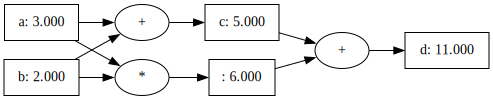

In [29]:
draw_dot(d)